# NSL-KDD Dataset: Analyzing Network Packets for Intrusion Detection

## Introduction
Most Intrusion Detection Systems (IDS) while detecting attacks also flags benign traffic as malicious. This poses a number of challenges:
- 'Operational Overhead' It requires resources to process and classify the flagged traffic 
- 'Alert Fatigue'(this goes for both human analysts and machine learning models exposed to too many false positives)

A common challenge with supervised learning is finding high-quality labeled data for training and testing models. While labeled pictures of cats are easy to obtain, labeled data from data breaches are much harder to come by. Options for labeled datasets for network traffic are somewhat limited, making the KDD dataset popular, especially for training and exploration. However, this also means that models trained on these datasets share similar characteristics.

Various models for IDS's using machine learning and deep learning neural networks have been proposed and implemented for research purposes by Sapre Et al. in [2] and Mijalkovic et al. in [3]  (the industry seems a bit closed regarding which datasets and models are implemented in products). The conclusuion is generally that the models reflect composition of the traffic and models are good at picking up DoS attacks and port scanning which happens a lot and less good at detecting foothold attempts and privilege escalation attacks .    

## Scope
Establish an overview of various machine learning models for analysis of networking traffic and investigate the relation between false positives and false negatives using confusion matrices. 
A baseline model will be adapted or established based a survey of various machine learning classifiers using following steps:
- Data Preparation
- Classification reduction
- Scaling to truncate large variations in magnitude for each feature
- Evaluate classifiers
- Paramter Study on False Poitives vs False Negatives (on a perfomant model based on previous step)
  
## Dataset
The NSL-KDD dataset is a subset of the KDDCup99 dataset, where repeated data was removed. The KDECup99 data were heavily skewed towards DoS Attacks causing arificilly high model performance (there was too much easily identifiable data in the set).

### Classification Reduction:  
Most machine learning models uses either binary classification (attack or not) or full classification (all classes). [1] suggests reducing it to 4 classes when using the NSL-KDD dataset, as it contains a lot of attack labels, some of which do not occur both in the proposed training and evaluation data.


# 1. Import Libraries

In [1]:
#!pip install seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams["figure.figsize"] = (10,6)

# 2. Preprocessing
Training and test data is read in to pandas dataframes for conveience

In [25]:
## Adapt as needed here, i downloaded the dataset locally
train_raw_data = pd.read_csv("KDDTrain+.txt")
test_raw_data = pd.read_csv("KDDTest+.txt")
df_test= test_raw_data.copy()
df_train= train_raw_data.copy()


## 2.1 Add Column/Feature Names
The files in the dataset do not contain any named features, below is from the dataset in KDD (https://www.kaggle.com/datasets/hassan06/nslkdd) these labels are added to the data below. 

In [4]:
print()

columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df_train.columns = columns
df_test.columns = columns
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.000,0.600,0.880,0.000,0.000,0.000,0.000,0.000,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.100,0.050,0.000,0.000,1.000,1.000,0.000,0.000,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.000,0.000,0.030,0.040,0.030,0.010,0.000,0.010,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.070,0.070,0.000,0.000,0.000,0.000,1.000,1.000,neptune,21


The KDD data have been explored here : https://www.kaggle.com/code/timgoodfellow/nsl-kdd-explorations
Wether the packed is malicous is listed in the 'attack' key with details (name of the attack)  
Inspired by [1] the attacks will be truncated into 5 catergories (including normal). 

In [5]:
## The types of attack in the data set are
df_comb = pd.concat([df_train['attack'], df_test['attack']]).unique() 
print(df_comb)
print("%i Combined Attack types" %len(df_comb))

['normal' 'neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap'
 'satan' 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop'
 'rootkit' 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land'
 'loadmodule' 'spy' 'perl' 'saint' 'mscan' 'apache2' 'snmpgetattack'
 'processtable' 'httptunnel' 'ps' 'snmpguess' 'mailbomb' 'named'
 'sendmail' 'xterm' 'worm' 'xlock' 'xsnoop' 'sqlattack' 'udpstorm']
40 Combined Attack types


## 2.2 Data reduction, Truncate Attack Categories
The data contains 40 different classifications, some of which are only present in the training data and vice versa for the test data. The categories cover a number of named network cyber attacks with 'normal' being benign and all the others being malicious. 
To reduce the number of classifications, and match the cetergories between test and train data, the attacks are truncated into 5 categories including normal [1] p207 as follows:
- benign: normal traffic 
- probe: enumration attempts, nmap scans etc.
- r2l: remote to local: remote login attempts to ftp ssh etc.  
- u2r: user to root, trying to escalate privileges using rootkits etc.
- dos: denial of service type attacks, syn floods ping of death etc.


In [6]:
## attack categories in dataset
truncate_dict= {
        'benign': ['normal'],
        'probe':  ['nmap', 'ipsweep', 'portsweep', 'satan',
                   'mscan', 'saint', 'worm'],
        'r2l':    ['ftp_write', 'guess_passwd', 'snmpguess',
                   'imap', 'spy', 'warezclient', 'warezmaster',
                   'multihop', 'phf', 'imap', 'named', 'sendmail',
                   'xlock', 'xsnoop', 'worm'],
        'u2r':    ['ps', 'buffer_overflow', 'perl', 'rootkit',
                   'loadmodule', 'xterm', 'sqlattack', 'httptunnel'],
        'dos':    ['apache2', 'back', 'mailbomb', 'processtable',
                   'snmpgetattack', 'teardrop', 'smurf', 'land',
                   'neptune', 'pod', 'udpstorm']
}

## Function to map values to the dictionary
def map_attack_type(attack):
    for key, values in truncate_dict.items():
        if attack in values:
            return key
    return 'unknown'  # Default value if the attack type is not found in the dictionary

## Map the truncated unto a new colum in the dataframes
df_train['attack_category'] = df_train['attack'].map(map_attack_type)
df_test['attack_category'] = df_test['attack'].map(map_attack_type)


In [7]:
df_train.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_category
0,0,udp,other,SF,146,0,0,0,0,0,...,0.600,0.880,0.000,0.000,0.000,0.000,0.000,normal,15,benign
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.050,0.000,0.000,1.000,1.000,0.000,0.000,neptune,19,dos
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.000,0.030,0.040,0.030,0.010,0.000,0.010,normal,21,benign
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,normal,21,benign
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.070,0.000,0.000,0.000,0.000,1.000,1.000,neptune,21,dos


Training Data
------------------------------------------------------------
attack_category
benign    67342
dos       45927
probe     11656
r2l         995
u2r          52
Name: count, dtype: int64


Test Data
------------------------------------------------------------
attack_category
benign    9711
dos       7635
r2l       2574
probe     2423
u2r        200
Name: count, dtype: int64


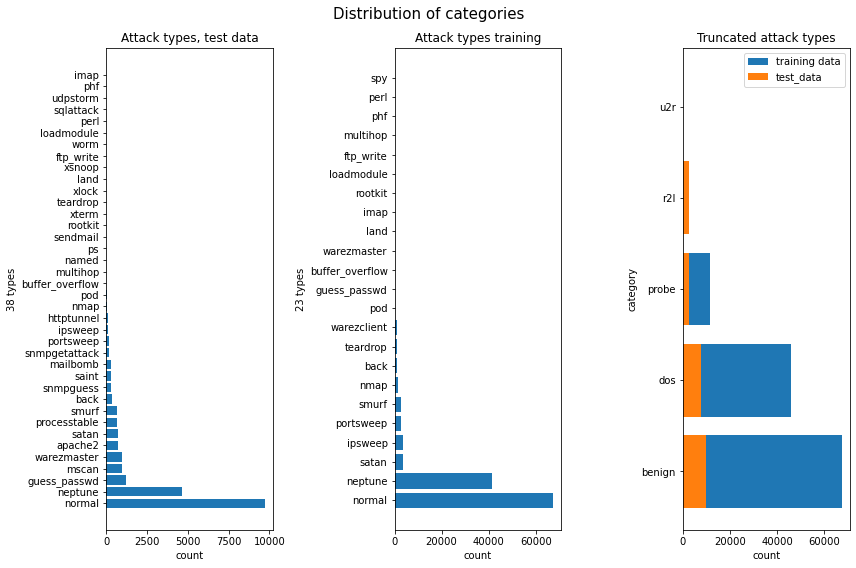

In [8]:
## 1 Check the categories and trucation added above

## training
train_attack_types = df_train['attack'].value_counts()
train_attack_categories = df_train['attack_category'].value_counts()
test_attack_types = df_test['attack'].value_counts()
test_attack_categories = df_test['attack_category'].value_counts()

fig = plt.figure(figsize=(12, 8), tight_layout=True)
fig.suptitle("Distribution of categories", fontsize = 15)

ax1 = fig.add_subplot(131)
ax1.barh(test_attack_types.index, test_attack_types)

ax1.set_xlabel("count")
ax1.set_ylabel('%i types' %len(test_attack_types))
ax1.set_title('Attack types, test data')


ax2 = fig.add_subplot(132)
ax2.barh(train_attack_types.index, train_attack_types)

ax2.set_xlabel("count")
ax2.set_ylabel('%i types' %len(train_attack_types))
ax2.set_title('Attack types training')

ax3 = fig.add_subplot(133)
ax3.barh(train_attack_categories.index, train_attack_categories)
ax3.barh(test_attack_categories.index, test_attack_categories)

ax3.set_xlabel("count")
ax3.set_ylabel('category')
ax3.set_title('Truncated attack types')
ax3.legend(['training data', 'test_data'])

print("Training Data")
print("--"*30)
print( train_attack_categories)
print('\n')
print("Test Data")
print("--"*30)
print(test_attack_categories)

Text(0.5, 1.0, 'Test Data')

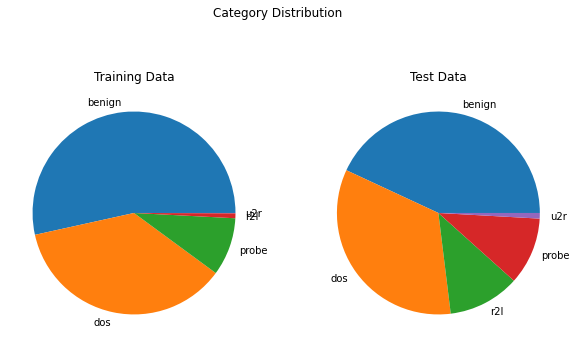

In [9]:
## Plot category distributions
fig = plt.figure()
fig.suptitle("Category Distribution")
ax1 = fig.add_subplot(121)
ax1.pie(train_attack_categories.values,  labels=train_attack_categories.index)
ax1.set_title("Training Data")


ax2 = fig.add_subplot(122)
ax2.pie(test_attack_categories.values,  labels=test_attack_categories.index)
ax2.set_title("Test Data")

## 2.3 Data types

In [10]:
## Chek datatypes of the whole dataset (test & training)
len_df_train = df_train.shape[0]
## Save a combined dataframe with all data 
## (STRICTLY for data conditioning, not supposed to combine training and test data!!!)
df_combi = pd.concat([df_train,df_test]) ## Save a comoined datafram with all data
df_combi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148515 entries, 0 to 22542
Data columns (total 44 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148515 non-null  int64  
 1   protocol_type                148515 non-null  object 
 2   service                      148515 non-null  object 
 3   flag                         148515 non-null  object 
 4   src_bytes                    148515 non-null  int64  
 5   dst_bytes                    148515 non-null  int64  
 6   land                         148515 non-null  int64  
 7   wrong_fragment               148515 non-null  int64  
 8   urgent                       148515 non-null  int64  
 9   hot                          148515 non-null  int64  
 10  num_failed_logins            148515 non-null  int64  
 11  logged_in                    148515 non-null  int64  
 12  num_compromised              148515 non-null  int64  
 13  root_

We have different types of dtypes, integers, floats and 'objects' which need encoding, doesn't seem like we have null values but we will check

## 2.4 Exploration Observations
- Fewer and different categories in training compared test data
- For the trunkated data, the r2l category is much less present in the training  data compared compared to test data
- For both the training data and the test data the 'u2r' categoy is very small
- There are some 'object' types that will need encoding
- The test data holds significantly more data in the 'r2l' category


Imbalance between normal and the minority categories, Undersampling will be implemented (works best according to [1])
Furthermeore the spread of attack types is different in the training vs the test data.

## 2.5 Data Cleaning

### 2.5.1 NULL's

In [11]:
if all(df_train.isnull().sum())==0:
    print("No Nulls found :-)")

No Nulls found :-)


### 2.5.2 Duplicates

In [12]:
#helper function for deeper analysis
def unique_values(df, columns):
    """Prints unique values and their counts for specific columns in the DataFrame."""

    for column_name in columns:
        print(f"Column: {column_name}\n{'-'*30}")
        unique_vals = df[column_name].unique()
        value_counts = df[column_name].value_counts()
        print(f"Unique Values ({len(unique_vals)}): {unique_vals}\n")
        print(f"Value Counts:\n{value_counts}\n{'='*40}\n")

In [13]:
cat_features = df_train.select_dtypes(include='object').columns
unique_values(df_train, cat_features)

Column: protocol_type
------------------------------
Unique Values (3): ['udp' 'tcp' 'icmp']

Value Counts:
protocol_type
tcp     102688
udp      14993
icmp      8291
Name: count, dtype: int64

Column: service
------------------------------
Unique Values (70): ['other' 'private' 'http' 'remote_job' 'ftp_data' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001' 'aol' 'http_2784' 'tftp_u' 'harvest']

Value Counts:
service
http         40338
private      21853
domain_u      9043
smtp          7313
ftp_data      6859
 

Further analysis will be in EDA-VISAULAZTION part about these column's impacts on Attacks

In [14]:
if df_train.duplicated().sum() == 0:
    print("No duplicates found in training data")

if df_train.duplicated().sum() != 0:
    print("%i duplicates found in the training data" %df.duplicated().sum())

No duplicates found in training data


### 2.5.3 Outliers

In [15]:
df_train.shape

(125972, 44)

<Figure size 1440x2880 with 0 Axes>

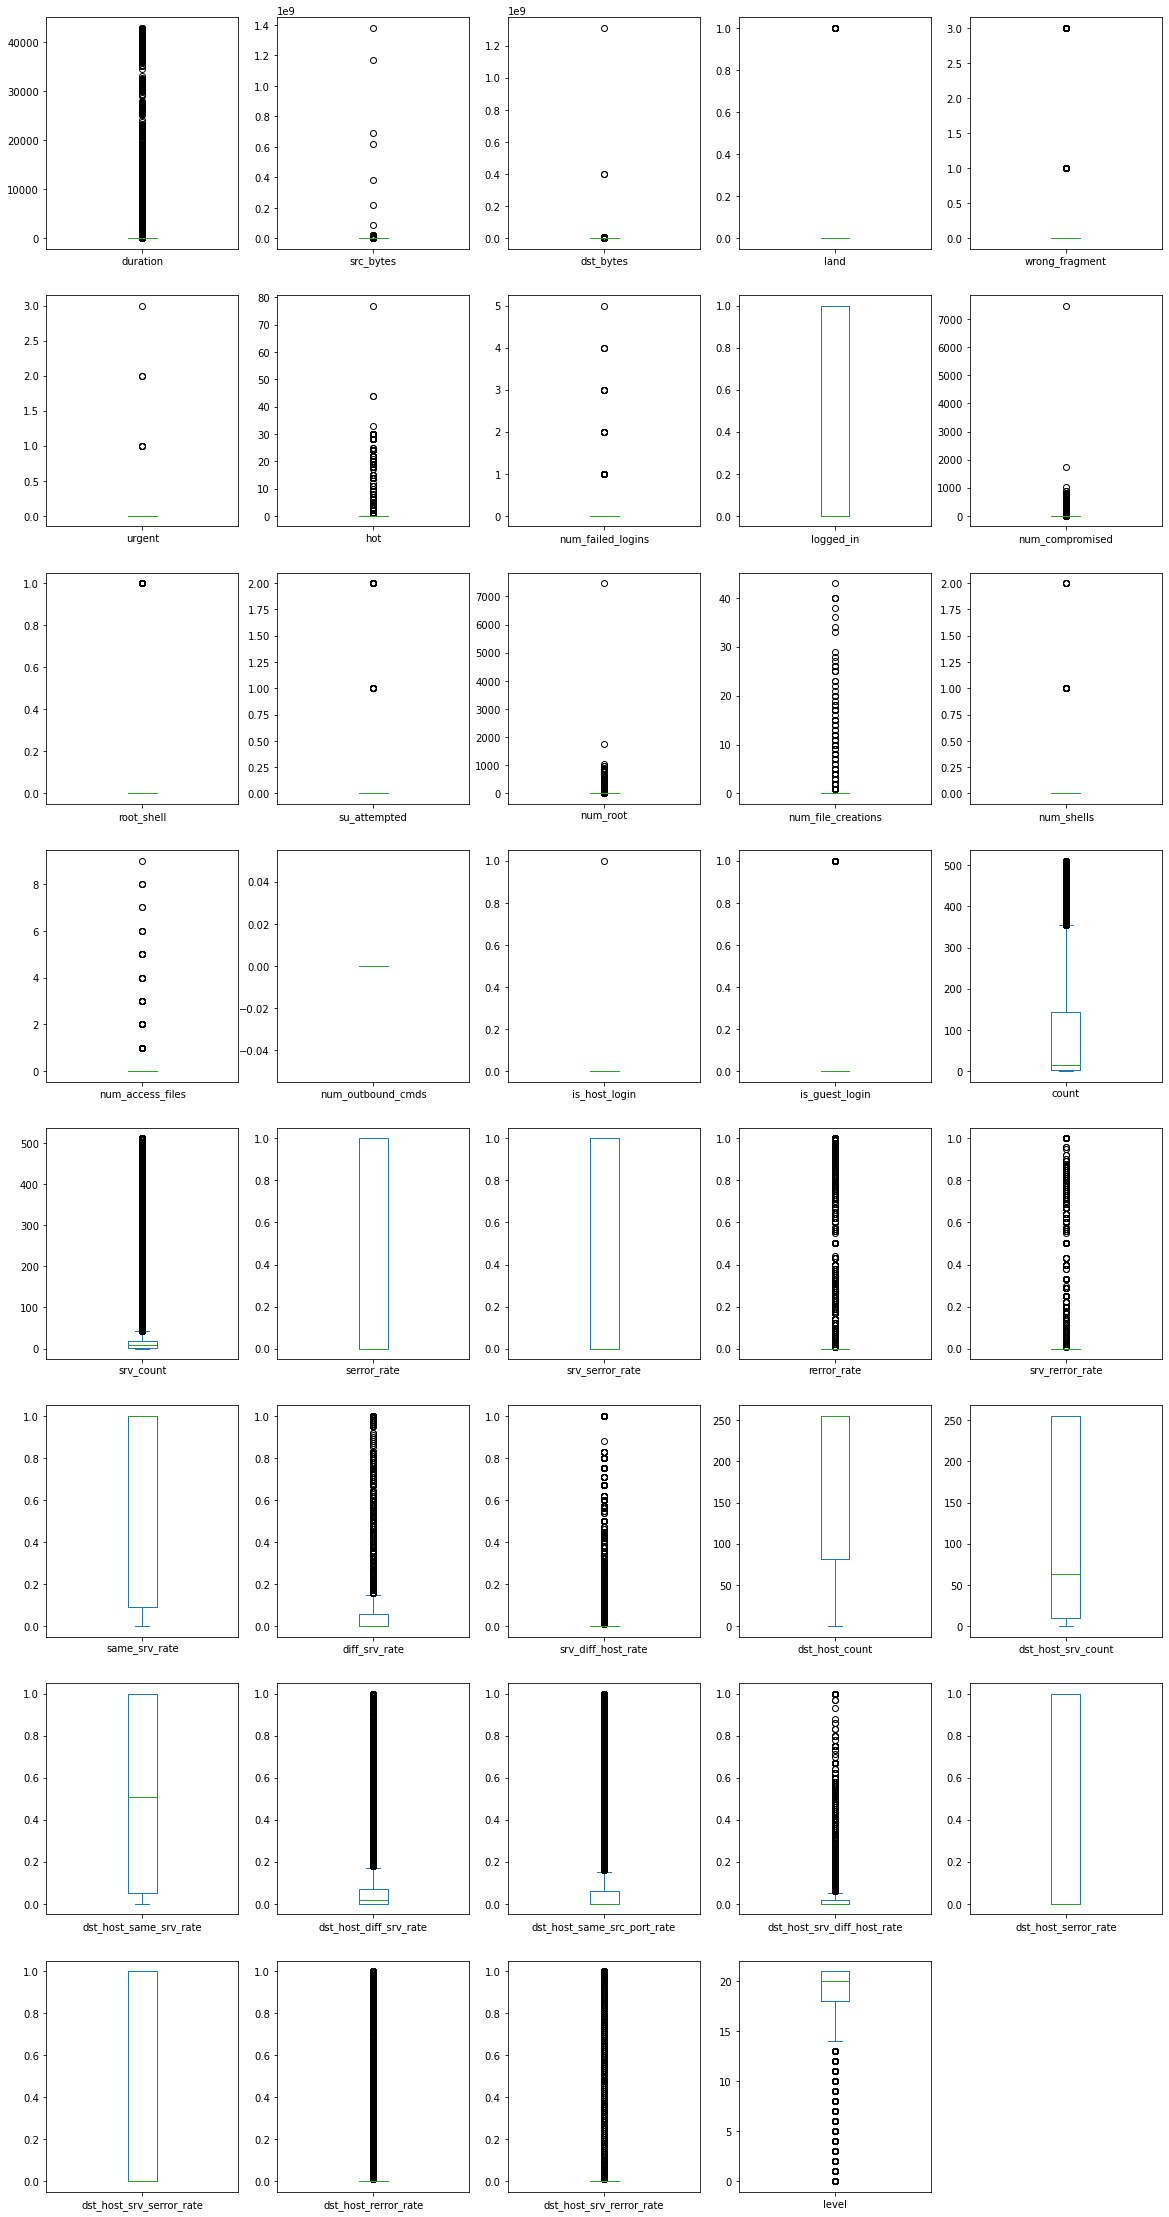

In [16]:
plt.figure(figsize=(20, 40))
## Filter out the non numerical data
num_columns = df_train.describe(exclude = 'object')
boxplot_df = df_train[num_columns.columns]
boxplot_df.plot(kind='box', subplots=True, layout=(8, 5), figsize=(20, 40))
plt.show()

#### Outlier's discussion
The box plots above show outliers are present on many features, this is in many cases to be expected with network traffic due to routing, traffic jams, bandwidth issues etc. Will ignore these for now (that is what is usually done with the NSL-KDD dataset in litterature [3])

## 3 Feature Engineering

### 3.1 The text 'object' features, one hot encoding
The text feature such as "protocol", "service", "attack catergory" is encoded using One-hotting 

In [17]:
## Address the "object" (text) variables
# 1   protocol_type                125972 non-null  object 
# 2   service                      125972 non-null  object 
# 3   flag                         125972 non-null  object 
# 41  attack                       125972 non-null  object 
# 43  attack_category              125972 non-null  object 

In [18]:
from sklearn.preprocessing import OneHotEncoder

## Labels for training and test
train_Y = df_train['attack_category']
test_Y = df_test['attack_category']


## Get the numerical feature names, working on the combined test and training data 
num_names = list(df_combi.select_dtypes(include='number').columns)
obj_names = list(df_combi.select_dtypes(include='object').columns)

## subtract the labels
obj_names = list(set(obj_names) - set(['attack', 'attack_category']))


## One hot encoder with a handy-dandy dataframe output
enc = OneHotEncoder(sparse_output = False).set_output(transform='pandas') 
train_transformed= enc.fit_transform(df_train[obj_names])
test_transformed = enc.transform(df_test[obj_names])

## Drop all the columms just one hot encoded
train_X = pd.concat([df_train.drop(obj_names, axis=1),train_transformed],axis=1)
test_X = pd.concat([df_test.drop(obj_names, axis=1),test_transformed],axis=1)

## Drop the labels and many attack categories
train_X=train_X.drop(['attack', 'attack_category'], axis=1)
test_X=test_X.drop(['attack', 'attack_category'], axis=1)




## 3.2 Standardization
The sklearn standard scaler is applied, moving all the data so the mean value is 0 and standard deviation is 1 for the training data!, the same sclaing paramters are then applied to the test data (which will not have a mean of 0 and a std_dev of 1)



In [19]:
## Multiple options here (Something to play around with)
from sklearn.preprocessing import StandardScaler

## Fit to training data
std_scaler = StandardScaler().fit(train_X[num_names])

## Save the un scaled data
train_XO = train_X
test_XO = test_X


## standardize train data
train_X[num_names] = std_scaler.transform(train_X[num_names])

## standardize test data using the same scaler!!
test_X[num_names] = std_scaler.transform(test_X[num_names])

print("The training data after scaling")
print("--"*30)
train_X.describe().T




The training data after scaling
------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
duration,125972.000,0.000,1.000,-0.110,-0.110,-0.110,-0.110,16.364
src_bytes,125972.000,-0.000,1.000,-0.008,-0.008,-0.008,-0.008,235.067
dst_bytes,125972.000,-0.000,1.000,-0.005,-0.005,-0.005,-0.005,325.747
land,125972.000,0.000,1.000,-0.014,-0.014,-0.014,-0.014,70.978
wrong_fragment,125972.000,0.000,1.000,-0.089,-0.089,-0.089,-0.089,11.743
...,...,...,...,...,...,...,...,...
service_urp_i,125972.000,0.005,0.069,0.000,0.000,0.000,0.000,1.000
service_uucp,125972.000,0.006,0.078,0.000,0.000,0.000,0.000,1.000
service_uucp_path,125972.000,0.005,0.074,0.000,0.000,0.000,0.000,1.000
service_vmnet,125972.000,0.005,0.070,0.000,0.000,0.000,0.000,1.000


# 4 Tour de Classifiers
Investigate which multinomial classifiers perform better with regards to false positives (and i also not too slow to compute)..
It could be argued that the models could be made Univariate, and reduce the classifiers to be 'benign' or 'not benign', but, at a later stage the purpose is to investigate which false negatives the model does not pick up, and the extra classifiers will help to identify which kinds of traffic the models does not pick up on..

- Logistic Regression: A linear model used for binary classification tasks, estimating the probability of a certain class.
- Decision Tree: Builds a tree structure where each node represents a decision based on a feature to partition data into classes.
- Random Forest: Constructs multiple decision trees and aggregates their predictions to improve accuracy and prevent overfitting.
- Gradient Boosting: Sequentially trains models to correct errors of predecessors, often achieving high accuracy.
- SVM (Support Vector Machine): Finds a hyperplane that best separates classes in high-dimensional space, using support vectors close to the decision boundary.
- k-NN (k-Nearest Neighbors): Classifies data points based on the majority class among their k nearest neighbors, useful for non-linear classification tasks.


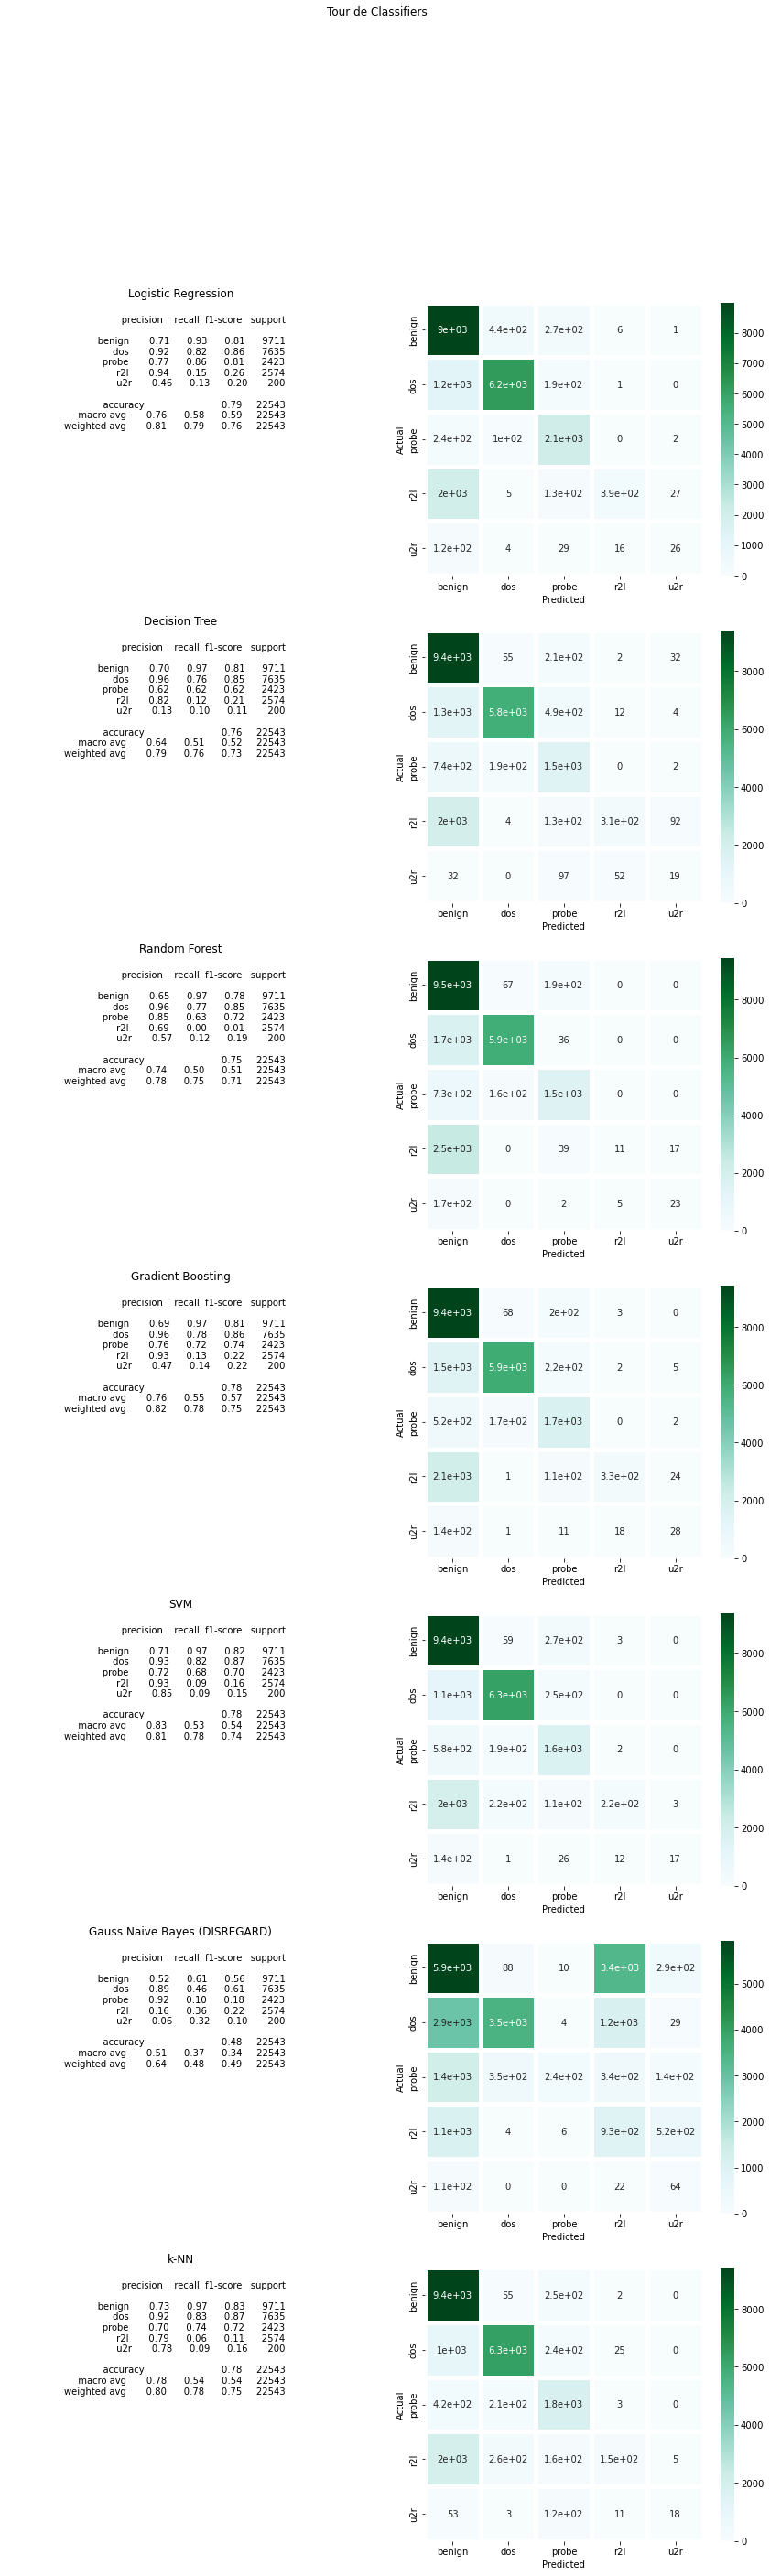

In [26]:
## import a slew of models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import seaborn as sn

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True),
    'Gauss Naive Bayes (DISREGARD)': GaussianNB(),
    'k-NN': KNeighborsClassifier()
}

## Reporting
n_models = len(models)
fig = plt.figure(figsize = (15,45))
fig.suptitle("Tour de Classifiers")
axs = fig.subplots(n_models,2)
## Run models
m=0
for name, model in models.items():
    model.fit(train_X, train_Y)
    pred_Y = model.predict(test_X)
    cfm = confusion_matrix(test_Y, pred_Y)
    
    ## Plot the confusion matrix
    cfm_df = pd.DataFrame(cfm, columns=np.unique(test_Y), index = np.unique(test_Y))
    cfm_df.index.name = 'Actual'
    cfm_df.columns.name = 'Predicted'

    axs[m,0].set_title("%s" %name)
    axs[m,0].text(0.8,0.5,"%s" %classification_report(test_Y, pred_Y),  horizontalalignment='right')
    axs[m,0].axis('off')
    
    sn.heatmap(cfm_df, ax=axs[m,1], cmap='BuGn', annot=True, annot_kws={"size":10}, linewidth=5)

    m=m+1
    
    #print(f"{name}:\n{classification_report(test_Y, pred_Y)}\n")


## 4.1 Remarks on Trour of Classifiers Results
Generally the models are good at predicting benign traffic and score above 0.75 in overall acuracy and and above .93 on recall for the benign case. 
Disregard the GaussianN Naive Bayes, which works better with continous classifiers.  
The  recall score for the benign case is interesting for evaluating false negatives (See Appendix ref on classification scores).

Looking at the confusion matrices above the models are classifying more of the u2r (priviledge escalation) and r2l (hacking attempts)  as 'benign' (missed) than thay classify 'malicous' this is also observed for the DoS and probe results however to a lesser degree. 

An interesting observation is that DecisionTree performs (marginally) better than RandomForest, which is basically more decision trees.

Logistic regresion performs best regarding precision, and f1 and has fast computation, however the recall score is lower compared to DecisionTree when looking at the 'benign' classifier. Therefore the DecisionTree classifier is used going forwards..

### Some Obeservations in relation to Intrusion Detection:
Eventhough the models score pretty good on overall recall and accuracy, there is a proportinally high number of u2r and r2l that are misclassified as benign.    



# 5 Classification Baseline
The DecisionTreeClassifier is used for speed and simplicity, the purpose is to identify false negatives (being well aware that false positives is a far bigger problem for IDS's in general)    

## 5.1 Parameter Optimization
Using scikit learn GridSerchCV, hyper paramter sets for optimised precision (score for the how good the model predicts results, i.e. attack or not) and for recall (taking false negatives into account) 
Optimization grid is mainly chosen for minimization of overfitting.

### Following is prepared:
- Labels are 'binarized' to 'benign' 0 or 'attack' , 1 
- The follwing paramters of the DecisionTree classifier is investigated:
  - 'max_depth': [None, 10, 20, 50],
  - 'min_samples_split': [2, 10, 20],
  - 'min_samples_leaf': [1, 5, 10],

#### max_depth:
Effect: Limits the maximum depth of the tree.
Influence: Prevents overfitting by restricting the complexity of the tree. A smaller max_depth can help generalize better to unseen data.

#### min_samples_split:
Effect: The minimum number of samples required to split an internal node.
Influence: Higher values prevent the model from learning overly specific patterns (overfitting), especially in datasets with many samples.

#### min_samples_leaf:
Effect: The minimum number of samples required to be at a leaf node.
Influence: Higher values can lead to a more generalized model by ensuring that leaves contain more samples.

In [21]:
## Parameters optimized for presicion

## Use GridSerach to explore HyperParameters
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score


## Binarize the labels
def binTrunc(i):
    if i != 'benign':
        return 0
    else:
        return 1

train_Ybin = train_Y
test_Ybin = test_Y

train_Ybin = train_Ybin.apply(binTrunc)
test_Ybin  = test_Ybin.apply(binTrunc)


## Parameter grid for exploration 
param_grid = {
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    #'max_features': [None, 'sqrt', 'log2'],
    #'criterion': ['gini', 'entropy'],
    #'splitter': ['random']
}

clf = DecisionTreeClassifier()

gridSearch = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='precision')

gridFit = gridSearch.fit(train_X,train_Ybin)

# Print the best parameters
print("Best parameters found: ", gridSearch.best_params_)


# Predict on test set
pred_ybin = gridSearch.predict(test_X)

# Evaluate the performance
accuracy = accuracy_score(test_Ybin, pred_ybin)
recall = recall_score(test_Ybin, pred_ybin)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Recall: {recall:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy: 0.8576
Test Recall: 0.9709


In [22]:
## Paramters optimized for good recall

train_Ybin = train_Y
test_Ybin = test_Y

train_Ybin = train_Ybin.apply(binTrunc)
test_Ybin  = test_Ybin.apply(binTrunc)

## Parameter grid for exploration 
param_grid = {
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    #'max_features': [None, 'sqrt', 'log2'],
    #'criterion': ['gini', 'entropy'],
    #'splitter': ['random']
}

clf = DecisionTreeClassifier()

gridSearch = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='recall')

gridFit = gridSearch.fit(train_X,train_Ybin)

# Print the best parameters
print("Best parameters found: ", gridSearch.best_params_)

# Predict on test set
pred_ybin = gridSearch.predict(test_X)

# Evaluate the performance
accuracy = accuracy_score(test_Ybin, pred_ybin)
recall = recall_score(test_Ybin, pred_ybin)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Recall: {recall:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy: 0.8429
Test Recall: 0.9680


## 5.2 Comments on parameter optimization
The two GridSearches produce very similar results, both regarding parameters, which are identical and respective results for precision and recall. 

## 5.3 Optimizing for a good recall score on r2l and u2r
This is a shot at optimizing for minimizing false negatives on the under represented 'hacking' and 'privilege escalation' classes eventhough these are a minority in the dataset

### Following is prepared:
- Labels are binarized so the r2l and u2r labels represent attack
- Same HyperParameter grid as above


In [23]:
## Paramters for good presicion

## Use GridSerach to explore HyperParamters
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score



## Binarize the labels
def binTrunc(i):
    if i == 'r2l':
        return 1
    elif i =='u2r':
        return 1
    else:
        return 0

train_Ybin = train_Y
test_Ybin = test_Y

train_Ybin = train_Ybin.apply(binTrunc)
test_Ybin  = test_Ybin.apply(binTrunc)

print(np.nonzero(test_Ybin))


## Parameter grid for exploration 
param_grid = {
    'max_depth': [None, 10, 20, 50, 100],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    #'max_features': [None, 'sqrt', 'log2'],
    #'criterion': ['gini', 'entropy'],
    #'splitter': ['random']
}

clf = DecisionTreeClassifier()

gridSearch = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='recall')

gridFit = gridSearch.fit(train_X,train_Ybin)

# Print the best parameters
print("Best parameters found: ", gridSearch.best_params_)


# Predict on test set
pred_ybin = gridSearch.predict(test_X)

# Evaluate the performance
accuracy = accuracy_score(test_Ybin, pred_ybin)
recall = recall_score(test_Ybin, pred_ybin)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Recall: {recall:.4f}")
print('Done')

(array([    6,     8,    36, ..., 22500, 22512, 22523]),)
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters found:  {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy: 0.9094
Test Recall: 0.2837
Done


## 5.4 Minority optimized model 
Taking a look at what a r2l/u2r optimized model looks like for the full spread of classifiers:

[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
['dos' 'benign' 'probe' ... 'dos' 'benign' 'probe']
['dos' 'benign' 'benign' ... 'dos' 'benign' 'benign']
Accuracy: 0.752
Done


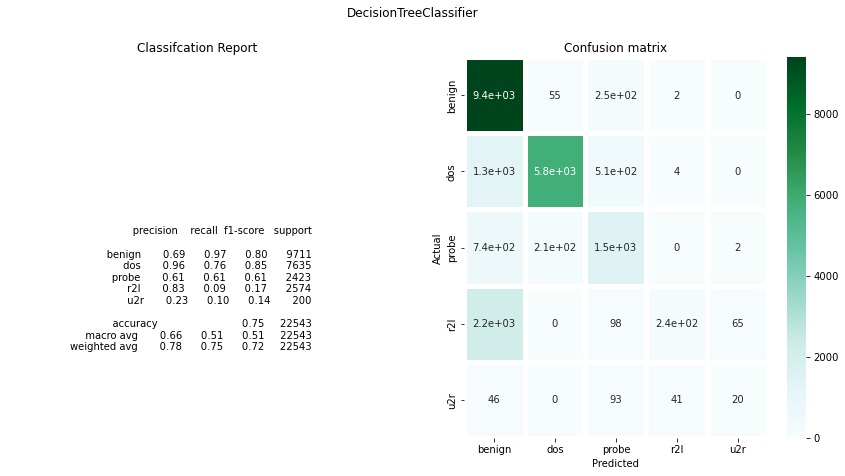

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   2.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=20; total time=   3.4s
[CV] END max_depth=None, min_samples_leaf=5, min_samples_split=10; total time=   2.6s
[CV] END max_depth=None, min_samples_leaf=5, min_samples_split=20; total time=   3.3s
[CV] END max_depth=None, min_samples_leaf=10, min_samples_split=10; total time=   3.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   2.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   2.9s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=2; total time=   2.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10; total time=   2.9s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=2; total time=   3.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=20; total time=   2.9s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2; to

In [24]:
## Multiple options NaiveBayes Multinomial logistic, Knneighbors etc,,

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import seaborn as sn

name = "DecisionTreeClassifier" 
clf = DecisionTreeClassifier(random_state=0, max_depth=None, min_samples_leaf=1,  min_samples_split=2)

trained = clf.fit(train_X,train_Y)

pred_Y = trained.predict(test_X)

cfm = confusion_matrix(test_Y, pred_Y)
acc = accuracy_score(test_Y, pred_Y)

predicted_probs = trained.predict_proba(test_X) ## DecisionTree outcome

print(predicted_probs)
print(test_Y.to_numpy())
print(pred_Y)


#correct_label_probs = predicted_probs[np.arange(len(test_Y.to_numpy())), test_Y.to_numpy()] ## The probability for the models pick out of the 5 labels
#max_predicted_probs = np.max(predicted_probs, axis = 1) ## the max probabilty found for the doc (which should be the right one)
#R_ratios = max_predicted_probs / correct_label_probs

#print(R_ratios)

## Plot the confusion matrix
cfm_df = pd.DataFrame(cfm, columns=np.unique(test_Y), index = np.unique(test_Y))
cfm_df.index.name = 'Actual'
cfm_df.columns.name = 'Predicted'
fig = plt.figure(figsize = (15,7))
fig.suptitle("%s" %name)


ax1 = fig.add_subplot(121)
ax1.set_title("Classifcation Report")
ax1.text(0.8,0.2,"%s" %classification_report(test_Y, pred_Y),  horizontalalignment='right')
ax1.axis('off')


ax2 = fig.add_subplot(122)
ax2.set_title("Confusion matrix")
sn.heatmap(cfm_df, ax=ax2, cmap='BuGn', annot=True, annot_kws={"size":10}, linewidth=5)


print(f"Accuracy: {acc:.3f}")
print("Done")

### Comments to r2l/u2r optimization
As expected this did not produce different results, the input parameters are similar to the previous.  

# Conclusion
This investigation shows that classification of network intrusion based on packet analysis is difficult.
Especially classification of 'remote to local' (r2l) and 'user to root' (u2r) type attacs [2] gives poor results especially regarding false negatives. These 2 categories,  are in many ways more severe compared to port scanning and DoS type attacks, as they indicate actual intrusion/escalation attempts. 
A reason for the difficulty in detecting r2l and u2r categories could be that they constitute a minority in the attack features and 
the models seem to be better at detecting traffic they are exposed to in higher quantities. 
    
Benign classification is also observed for the DoS and probe results, however to a lesser extent. I think it makes more sense for these categories as probe traffic occurs for beningn purposes all the time, and the dos attacks are basically beign traffic - just more of it..

An interesting observation is that DecisionTree performs (marginally) better than RandomForest, which is basically more decision trees. This is likely due to lack of Variance in the data as network packets are very similar. 

Variance is generally an issue when looking at network packets, they are very similar especially when looked at individually. Data packets that are malicious look like their benign counterparts. Moreover, in actual attacks network traffic is often deliberately hidden in benign traffic, making detection by individual packet analysis impossible.     

An impotant 'feature' of the NSL-KDD dataset is that it does not take relation between packets into account, models look at packets individuially and does not take things like TCP streams into account. I guess some relation could be re-created based on the features containing number of connections, durations or byte counts of the packet payloads. Future datasets should (and probalby are) include(ing) session id, durations etc. so sessions and TCP streams could be implemented.   

Currently it is difficult to build an effective IDE based solely on analysis of individual network packets. To be effective, an IDS should incorporate information about benign baseline traffic to distinguish 'out-of-normal' traffic. Additionally, packet payload inspection should be included, with detection based on deviations from normal behavior. IDS systems need to be tailored and continuously adapted based on their deployment environment.    
 

# References
- [1] Machine Learning and Security, Clarence Chio & David Freeman 2018
- [2] Sapre, Suchet & Ahmadi, Pouyan & Islam, Khondkar. (2019). A Robust Comparison of the KDDCup99 and NSL-KDD IoT Network Intrusion Detection Datasets Through Various Machine Learning Algorithms. 1999
- [3] Mijalkovic, J.; Spognardi, A. "Reducing the False Negative Rate in Deep Learning Based Network Intrusion Detection Systems" Algorithms 2022, 15, 258. https://doi.org/10.3390/a15080258

# Appendix


## Classificaton report metrics:
### **Accuracy**

Accuracy is the most common metric to be used in everyday talk. Accuracy answers the question **“Out of all the predictions we made, how many were true?”**


![](https://cdn.prod.website-files.com/5fed49be52334588b156311c/6369312b86fe50cbb5aff369_s5DUTobZ_IV81v5DRuVDP8x4TGzIgu6HBRnU2uFw6GAJeotedHvzL6COHit7yz7Uuvs8wieZIe2gCJNy4RkZQHZSzZqehgr8MngwkhbcI0p0loYlC35lKgzonTlvroC5t0Swwp820neVOEgsDWwlzfuWWLCmp_tSQIU5xVVKC6bd2lKV67_AbMDTVOnw5w.png)


As we will see later, accuracy is a blunt measure and can sometimes be misleading.


### **Precision** 


Precision is a metric that gives you the proportion of true positives to the amount of total positives that the model predicts. It answers the question **“Out of all the positive predictions we made, how many were true?”**


![](https://cdn.prod.website-files.com/5fed49be52334588b156311c/6369312b93b4e700f7ed539f_F0UROoldDgIawO9KVBShiUK2lDPt1v5wTm5YMr-oOE83oOBbMMkWYOEeZnnWGI-0ZwwcNx1BvMGKSv-GbF4pggh2q8Z6P1fQgboW2zL6ktqOaJetXbGSUQFx6P1Ah-Zz8XPB596qGuhXzLdJyhv0altnSKkqlw1veOuvvPjLU8NcGNVlpTTl-PYhyZLN5Q.png)

‍
### **Recall** 


Recall  focuses on how good the model is at finding all the positives. Recall is also called true positive rate and answers the question “**Out of all the data points that should be predicted as true, how many did we correctly predict as true?**”


![](https://cdn.prod.website-files.com/5fed49be52334588b156311c/6369312bddc623f50aa43b52_Ttp9NjMsqUUS0vllpfAWCC6lLMbluniEMHDBspNXPNKi7iDThZzJ-xMgHL5vDWnKdElq50g0wvBxIco9oaY8_sBbqxpr0H_4twHr2fyOjB6sm2g9B2V9cojcc44dcRLVyUKmfH4VsbfVGSWwcrce40ONkrRm0FBJ8ZKo6AiNH2KSWsDD8hJSmBXMSk7Fpg.png)


As you can see from the definitions of precision and recall they are tightly connected. 

### **F1 Score**
F1 Score is a measure that combines recall and precision. As we have seen there is a trade-off between precision and recall, F1 can therefore be used to measure how effectively our models make that trade-off.

![](https://cdn.prod.website-files.com/5fed49be52334588b156311c/6369312b1a6a71e630ff6647_AxQGlrOBWDDXnJ1vy1RJw84ZxP9kwM6V20lnT4YOie8uFDFWJYKdCVULk-LBENS4QVQxAgrXhXaPCI3UnNza5gBXoHk0-W2lWCxfzeRr4MEunBo5gtLh5yOtZEMuUQkHwikAjm6YGBTUyOxjmro13KUPHhbjiei37LzZnytsZhbRSwiF4236Bx9JBjArIQ.png)

One important feature of the F1 score is that the result is zero if any of the components (precision or recall) fall to zero. Thereby it penalizes extreme negative values of either component.